In [1]:
# dependency to use the "feather" data storage format
# conda install pyarrow

## Get Hourly Electric Demand data

Fetch from the utility's public FTP site while it lasts

## This takes about 1 minute to run if the data has already been downloaded once

Downloaded files will be stored in downloads/ for faster processing next time

Downloading the first time may take much longer due to the source files being rate-limited

## Note: if you got this from my github, you don't have to run this

The data has all been saved in the dataframes/ directory in both the (slow and safe) csv.gz format and the (fast and dangerous) .pickle.gz format


In [2]:
import urllib.request
import os

downloads_dir = 'downloads/'
years_to_load = ['2015', '2016', '2017', '2018', '2019']

sourceurl = 'ftp://pubftp.spp.org/Operational_Data/HourlyLoad/%s/%s.zip'

for year in years_to_load:
    if os.path.exists(downloads_dir + year + '.zip') == False: 
        print ("Trying to retrieve hourly demand for " + year, end=' ... ', flush=True)
        urllib.request.urlretrieve(sourceurl%(year, year), downloads_dir + year + ".zip")
        print ("done")
    else:
        print (downloads_dir + year + ".zip already downloaded")


downloads/2015.zip already downloaded
downloads/2016.zip already downloaded
downloads/2017.zip already downloaded
downloads/2018.zip already downloaded
downloads/2019.zip already downloaded


In [3]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import io

try: 
    del demand_df
except: 
    pass

for year in years_to_load:
    with ZipFile(downloads_dir + year + '.zip', 'r') as zipObj:
        # Get list of files names in zip
        listOfiles = zipObj.namelist()
        # Iterate over the list of file names in given list & print them
        for elem in listOfiles:
#            print(elem)
            if (elem.split('.')[-1:][0] == 'csv'):
                df = pd.read_csv(io.BytesIO( zipObj.read(elem)) ) 
                try: 
                    demand_df = demand_df.append(df)
                except: 
                    demand_df = df

demand_df = demand_df.reset_index(drop=True)
demand_df.head()

,MarketHour,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE
0,7/1/2015 6:00,5764.911333,596.281417,799.847667,123.030083,296.929250,1949.042000,372.480333,1018.514250,2219.108833,4117.08400,1258.544250,887.502083,395.434000,3920.596000,1111.297750,3961.901250,NaN
1,7/1/2015 7:00,5412.822750,564.420333,822.521167,108.127000,280.323917,1801.828333,348.362333,961.898000,2123.033417,3873.73125,1184.703333,845.620500,371.291667,3786.391167,1065.715000,3744.169250,NaN
2,7/1/2015 8:00,5159.626583,545.948917,807.133917,98.328583,270.348250,1666.008583,329.306750,896.261500,2046.187250,3706.41750,1140.597083,812.216833,356.816583,3694.294667,1032.225750,3591.133583,NaN
3,7/1/2015 9:00,4995.453167,534.070417,798.911667,96.420667,262.933333,1607.743750,323.767583,868.995833,1994.560333,3578.15025,1115.101833,792.190417,347.746083,3631.846917,1008.360917,3487.656750,NaN
4,7/1/2015 10:00,4936.187167,538.574083,797.087083,95.493000,261.330417,1608.171667,325.644667,866.115250,1999.117083,3511.46950,1127.351583,784.963750,351.444917,3601.413083,986.151417,3465.577667,NaN


In [4]:
# Yikes, all my column names start with spaces. Fix that real quick:
renamedict={}
for i in demand_df.columns: 
    if i.startswith(' '):
        renamedict[i] = i[1:]
demand_df.rename(columns=renamedict, inplace=True)
demand_df.columns

Index(['MarketHour', 'CSWS', 'EDE', 'GRDA', 'INDN', 'KACY', 'KCPL', 'LES',
       'MPS', 'NPPD', 'OKGE', 'OPPD', 'SECI', 'SPRM', 'SPS', 'WFEC', 'WR',
       'WAUE'],
      dtype='object')

In [5]:
demand_df.count()

MarketHour    46342
CSWS          46335
EDE           46335
GRDA          46342
INDN          46335
KACY          46335
KCPL          46335
LES           46335
MPS           46335
NPPD          46342
OKGE          46335
OPPD          46335
SECI          46335
SPRM          46335
SPS           46335
WFEC          46335
WR            46335
WAUE          39784
dtype: int64

In [6]:
# drop rows where MarketHour is all blanks (https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe)

demand_df['MarketHour'].replace('', np.nan, inplace=True)
demand_df.dropna(subset=['MarketHour'], inplace=True)
demand_df.count()

# also there are a handful of bad rows where CSWS and others are blank
demand_df['CSWS'].replace('', np.nan, inplace=True)
demand_df.dropna(subset=['CSWS'], inplace=True)
demand_df.count()


MarketHour    46335
CSWS          46335
EDE           46335
GRDA          46335
INDN          46335
KACY          46335
KCPL          46335
LES           46335
MPS           46335
NPPD          46335
OKGE          46335
OPPD          46335
SECI          46335
SPRM          46335
SPS           46335
WFEC          46335
WR            46335
WAUE          39784
dtype: int64

## What is the last MarketHour really?  And what is that silly time format? 

I am amzaed; I have spent weeks of my life dealing with bad timestamp formats and this one line of code fixes them

In [7]:
pd.to_datetime(['2021-09-01 17:00', '16-Jul-1970 3:30PM', '9/11/2001 8:46AM', '3/4/5 6:7' ])
# wow.

DatetimeIndex(['2021-09-01 17:00:00', '1970-07-16 15:30:00',
               '2001-09-11 08:46:00', '2005-03-04 06:07:00'],
              dtype='datetime64[ns]', freq=None)

In [8]:
demand_df['MarketHour'] = pd.to_datetime(demand_df.MarketHour)

In [9]:
demand_df.sort_values(by='MarketHour', inplace=True, ignore_index=True)
demand_df.tail()

,MarketHour,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE
46330,2020-01-01 04:00:00,5545.088,630.389,615.696,113.786,249.791,1676.336,382.204,994.151,1933.474,3751.846,1313.509,675.244,347.436,3698.425,1180.288,3313.351,3870.478
46331,2020-01-01 05:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432
46332,2020-01-01 05:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432
46333,2020-01-01 06:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911
46334,2020-01-01 06:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911


## MarketHour is in an industry format known as Hour Ending GMT.
So the demand reported for 2020-01-01 06:00:00 is summed over the last hour of 2019, which ends at the start of the first hour of 2020.  This is an inconvenient format because grouping to a higher time level like day or month is difficult. So, I want to subtract an hour from each MarketHour and call it HourBeginUTC so we are all clear on what it means, and all the hours for a given day match that day. 

In [10]:
demand_df.MarketHour -= pd.Timedelta("1 hour")
demand_df.rename(columns={"MarketHour":"HourBeginUTC"}, inplace=True)

# Convert UTC to US/Central
# OMG this is an ugly hack please refactor correctly
demand_df['HourBeginCPT']=demand_df.HourBeginUTC.dt.tz_localize('utc').dt.tz_convert('US/Central')
demand_df.tail()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT
46330,2020-01-01 03:00:00,5545.088,630.389,615.696,113.786,249.791,1676.336,382.204,994.151,1933.474,3751.846,1313.509,675.244,347.436,3698.425,1180.288,3313.351,3870.478,2019-12-31 21:00:00-06:00
46331,2020-01-01 04:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432,2019-12-31 22:00:00-06:00
46332,2020-01-01 04:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432,2019-12-31 22:00:00-06:00
46333,2020-01-01 05:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911,2019-12-31 23:00:00-06:00
46334,2020-01-01 05:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911,2019-12-31 23:00:00-06:00


## I see some duplicate rows, due to the way the files are stored on the source site.

De-duplicate: 

In [11]:
 
demand_df.drop_duplicates(subset='HourBeginUTC', keep='first', ignore_index=True, inplace=True)
demand_df.tail()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT
43809,2020-01-01 01:00:00,5577.976,642.424,620.169,122.165,261.041,1844.867,403.365,1036.075,1990.111,3764.081,1378.452,655.260,366.549,3709.873,1173.041,3408.587,4006.754,2019-12-31 19:00:00-06:00
43810,2020-01-01 02:00:00,5592.408,637.974,617.084,117.503,255.755,1729.733,393.802,1015.739,1971.021,3790.055,1347.326,659.367,357.205,3713.646,1182.855,3358.233,3954.821,2019-12-31 20:00:00-06:00
43811,2020-01-01 03:00:00,5545.088,630.389,615.696,113.786,249.791,1676.336,382.204,994.151,1933.474,3751.846,1313.509,675.244,347.436,3698.425,1180.288,3313.351,3870.478,2019-12-31 21:00:00-06:00
43812,2020-01-01 04:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432,2019-12-31 22:00:00-06:00
43813,2020-01-01 05:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911,2019-12-31 23:00:00-06:00


In [12]:
print ("Expecting 5 years of hours, or about ", 365.25*5*24, "observations")
demand_df.count()

Expecting 5 years of hours, or about  43830.0 observations


HourBeginUTC    43814
CSWS            43814
EDE             43814
GRDA            43814
INDN            43814
KACY            43814
KCPL            43814
LES             43814
MPS             43814
NPPD            43814
OKGE            43814
OPPD            43814
SECI            43814
SPRM            43814
SPS             43814
WFEC            43814
WR              43814
WAUE            37263
HourBeginCPT    43814
dtype: int64

## The original analysis explained footprint-wide demand based on temperature.  
Add a "SPP" column that is the fooprint wide demand:
    

In [13]:
demand_df['SPP'] = demand_df.sum(axis=1, skipna=True, level=None, numeric_only=True, min_count=0)
demand_df.head()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT,SPP
0,2015-01-01 06:00:00,5414.428667,690.353417,601.328750,118.009833,276.281583,2024.031667,408.098083,1123.670750,2032.943583,3718.808250,1360.804917,640.972083,348.984417,3652.834250,1278.617250,3485.146083,NaN,2015-01-01 00:00:00-06:00,27175.313583
1,2015-01-01 07:00:00,5302.293083,680.900667,597.834167,114.609833,271.804583,1994.646167,397.742000,1103.481000,2003.725500,3632.980083,1333.814083,632.309917,341.540833,3611.853250,1254.872667,3407.070833,NaN,2015-01-01 01:00:00-06:00,26681.478666
2,2015-01-01 08:00:00,5216.567250,673.748083,593.313833,112.229417,268.632583,1976.253083,391.534167,1089.126833,1994.740250,3568.703333,1311.999667,625.976417,337.476333,3576.350417,1243.953083,3356.186000,NaN,2015-01-01 02:00:00-06:00,26336.790749
3,2015-01-01 09:00:00,5194.792500,671.118750,587.518667,111.352250,267.114667,1961.418333,389.246833,1081.688000,1979.505833,3543.309417,1299.054417,616.841000,336.480417,3555.746333,1239.468000,3330.177917,NaN,2015-01-01 03:00:00-06:00,26164.833334
4,2015-01-01 10:00:00,5228.730250,676.443417,589.542750,111.619000,265.789917,1965.443250,390.444917,1084.774417,1962.926083,3544.051917,1300.289667,616.814000,339.956333,3551.315500,1247.401917,3331.898667,NaN,2015-01-01 04:00:00-06:00,26207.442002


## One company WAUE has fewer rows; it probably joined at a later date. See if we can tell when:


In [14]:
demand_df[['HourBeginUTC', 'WAUE']].dropna()

,HourBeginUTC,WAUE
6551,2015-10-01 05:00:00,2347.347833
6552,2015-10-01 06:00:00,2286.531417
6553,2015-10-01 07:00:00,2269.494167
6554,2015-10-01 08:00:00,2270.933333
6555,2015-10-01 09:00:00,2282.437500
...,...,...
43809,2020-01-01 01:00:00,4006.754000
43810,2020-01-01 02:00:00,3954.821000
43811,2020-01-01 03:00:00,3870.478000
43812,2020-01-01 04:00:00,3781.432000


In [15]:
# That's still a lot of data; just go with the uniform footprint by dropping all N/A columns for now.
demand_df = demand_df.dropna().reset_index(drop=True)
demand_df.head()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT,SPP
0,2015-10-01 05:00:00,4360.491167,415.597917,646.765000,73.082583,239.346833,1419.786750,278.846667,692.616000,1228.483167,2976.058583,1010.840083,634.102250,276.964000,3256.031833,895.474833,2732.193500,2347.347833,2015-10-01 00:00:00-05:00,23484.028999
1,2015-10-01 06:00:00,4162.974250,396.663500,637.096333,69.710000,234.887833,1368.187500,266.692083,668.131083,1303.743167,2827.436083,971.378167,619.002333,263.131000,3172.048333,878.405083,2640.415750,2286.531417,2015-10-01 01:00:00-05:00,22766.433915
2,2015-10-01 07:00:00,4037.322000,385.453250,627.696000,67.830250,230.520417,1339.521583,259.356583,652.154417,1278.170917,2730.560583,957.438000,618.973500,257.112167,3112.841917,863.035333,2578.261250,2269.494167,2015-10-01 02:00:00-05:00,22265.742334
3,2015-10-01 08:00:00,3955.691000,380.674167,623.709083,67.688083,229.492000,1334.550750,255.560417,649.930667,1267.810000,2670.254000,950.869583,618.097000,253.720167,3083.121167,849.819833,2550.379333,2270.933333,2015-10-01 03:00:00-05:00,22012.300583
4,2015-10-01 09:00:00,3942.895500,390.002000,627.155250,69.333667,232.110917,1350.949750,259.912917,663.529667,1280.857167,2697.356000,964.447333,617.443750,256.428917,3061.377750,845.748833,2589.835583,2282.437500,2015-10-01 04:00:00-05:00,22131.822501


## It is always useful to visualize the data to see if it makes sense

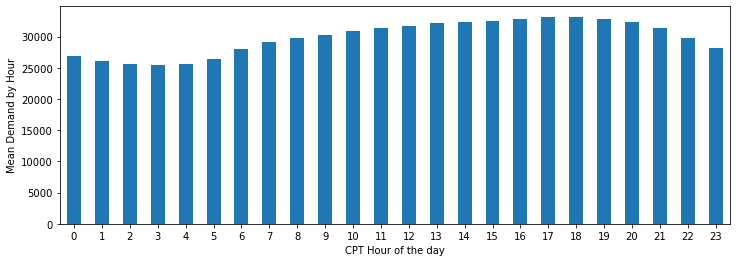

In [16]:
# from https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
# which has other good tips

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
demand_df.groupby(demand_df["HourBeginCPT"].dt.hour)["SPP"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("CPT Hour of the day");  # custom x label using matplotlib
plt.ylabel("Mean Demand by Hour");


## Save out the hourly demand dataframe

In [17]:
# that's pretty clean. Save it off for further verification. 

# CSV has problems with datatypes and indexes:
demand_df.to_csv('dataframes/demand_df.csv.gz', compression='infer', index=False)

# Pickle works perfectly if you don't have to change Python versions (such as PC to Google Colab)
# demand_df.to_pickle('dataframes/demand_df.pickle.gz', compression='infer')

# Trying Feather
#demand_df.to_feather('dataframes/demand_df.feather.zstd', compression='zstd')

# Trying JSON
# demand_df.to_json('dataframes/demand_df.json.gz', compression='infer')

## The original analysis predicted total daily demand, not total hourly demand. 

To compare with the orignal, I'll sum to the daily level too and save that




In [18]:
# this didn't work; I need to truncate the hour to the day level before the group by 
# demand_df.groupby(['HourBeginUTC'])['SPP'].sum().reset_index()

# maybe use The resample() method is similar to a groupby operation:

#    it provides a time-based grouping, by using a string (e.g. M, 5H,…) that defines the target frequency

#    it requires an aggregation function such as mean, max,…

# this still doesn't work: 
# daily_sum = demand_df.resample("M").sum()


In [19]:
# but I sure can cheat with SQLite: https://pythonspeed.com/articles/indexing-pandas-sqlite/
import sqlite3
con=sqlite3.connect("")
demand_df.to_sql('demand_df', con, if_exists='replace', index=False)

daily_demand_df=pd.read_sql("""
select datetime( HourBeginCPT, \'start of day\') as opday, 
sum(SPP) as sum_spp_load
from demand_df
group by datetime( HourBeginCPT, \'start of day\')
""", con)
daily_demand_df['opday'] = pd.to_datetime(daily_demand_df.opday)

daily_demand_df.head()

# todo:  replace this with one line of Pandas

,opday,sum_spp_load
0,2015-10-01,502184.942993
1,2015-10-02,612695.032412
2,2015-10-03,566229.834662
3,2015-10-04,552166.723416
4,2015-10-05,596751.461994


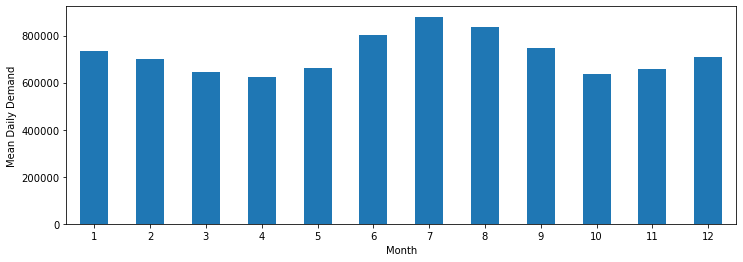

In [20]:
# from https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
# which has other good tips

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
daily_demand_df.groupby(daily_demand_df["opday"].dt.month)["sum_spp_load"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Mean Daily Demand");


## WAUE started 10/1/2015 06:00. 

So we need to either drop rows before then, or feed another weather station into the model.  We probably have enough data wihout those values before 10/1/2015. 

## Save out the daily demand dataframe

In [21]:
# save daily_demand_df 

daily_demand_df.to_csv('dataframes/daily_demand_df.csv.gz', compression='infer', index=False)

# daily_demand_df.to_pickle('dataframes/daily_demand_df.pickle.gz', compression='infer')
# Trying Feather
# daily_demand_df.to_feather('dataframes/daily_demand_df.feather.zstd', compression='zstd')
# Trying JSON
# daily_demand_df.to_json('dataframes/daily_demand_df.json.gz', compression='infer')

 * 
 *
 *
 * 
 *
 *
 
# Now look for weather station data

These daily weather datasets are documeted at https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/


## Get a list of all weather stations with available data

In [22]:
sourceurl = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/ghcnd-stations.txt'
save_file = downloads_dir + 'ghcnd-stations.txt'
if os.path.exists(save_file) == False: 
    print ("Trying to retrieve " + sourceurl + " to " + save_file, end=' ... ', flush=True)
    urllib.request.urlretrieve(sourceurl, save_file)
    print ("done")
else:
    print (save_file + " already downloaded")
    

downloads/ghcnd-stations.txt already downloaded


In [23]:
# load station file from NOAA site; it is fixed-width formatted.

st_df = pd.read_fwf(save_file, 
                 widths=[11,1,8,1,9,1,6,1,2,1,30,1,3,1,3,1,5])
    

In [24]:
# rename columns and drop spaces
st_df.rename(columns={'ACW00011604' : 'station',
                   '17.1167' : 'latitude',
                   '-61.7833' : 'longitude',
                   '10.1' : 'altitude?',
                   'ST JOHNS COOLIDGE FLD' : 'station name',
                   'Unnamed: 16' : 'zip code',
                   'Unnamed: 8' : 'state code',
                   }, inplace=True)

st_df = st_df[['station', 'station name', 'latitude', 'longitude', 'state code', 'zip code']]

## We are interested only in weather stations that could impact demand in the utility footprint*. 

Very roughly, this is a box from latitudes 31 to 100, and longitudes -106 to -92.  If the station is outside that box, we can not consider it a predictor of demand in SPP.  This excludes most of the stations in the list.

(*) I thought this was true but it may not be.  For instance, Little Rock is consistently one of the most predictive stations, as well as others outside the untility.  The electric grid is interconnected and demand may be reflecting those outside connections. 


In [25]:
st_df = st_df.loc[(st_df['longitude'] >=  -106) &
        (st_df['longitude'] <=  -92)  & 
        (st_df['latitude'] >=  31)  & 
        (st_df['latitude'] <=  100) &
        (st_df['station'].str.contains("USW"))
       ]
st_df

,station,station name,latitude,longitude,state code,zip code
115959,USW00003013,LAMAR MUNI AP,38.0700,-102.6881,CO,NaN
115961,USW00003017,DENVER INTL AP,39.8328,-104.6575,CO,72565.0
115962,USW00003024,BORGER HUTCHINSON CO AP,35.6950,-101.3950,TX,NaN
115963,USW00003026,BURLINGTON CARSON AP,39.2447,-102.2842,CO,NaN
115964,USW00003027,CLINES CORNERS,35.0028,-105.6628,NM,NaN
...,...,...,...,...,...,...
117688,USW00094990,WINNER WILEY FLD,43.3906,-99.8422,SD,NaN
117689,USW00094991,LAMONI MUNI AP,40.6331,-93.9019,IA,NaN
117691,USW00094993,SISSETON MUNI AP,45.6689,-96.9914,SD,NaN
117693,USW00094995,LINCOLN 8 ENE,40.8483,-96.5650,NE,74442.0


In [26]:
# define a lookup from the station ID to the station name

def station_name(station): 
    df = st_df[st_df.station == station][['state code','station name']]
#    print (str(df.values))
    return '_'.join(df.values[0]).replace(' ', '_')
    
    
station_name('USW00094990')

'SD_WINNER_WILEY_FLD'

## Download selected weather stations. 

Note: the initial analysis uses only this station list: 

In [27]:
# The orignal analysis looked at these stations       
stations_to_load = [
    'USW00013967',  # Oklahoma City OK
    'USW00013996',  # Topeka KS 
    'USW00023047',  # Amarillo TX
    'USW00013968',  # Tulsa OK
    'USW00014939',  # Lincoln NE 
    'USW00024011',  # Bismark ND
]
       
# but learning from genetic algorithm shows these to be better: 
# 'TAVG_KS_DODGE_CITY', 'TAVG_KS_TOPEKA_MUNI_AP', 'TAVG_LA_SHREVEPORT', 'TAVG_MO_SPRINGFIELD',
# 'TAVG_NE_LINCOLN_MUNI_AP', 'TAVG_OK_LAWTON_MUNI_AP',  'TAVG_WY_TORRINGTON_MUNI_AP'],
     

In [28]:

# but temporarily load them ALL for a possible genetic-algorithm search for the best ones 

stations_to_load = st_df.station

sourceurl = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/%s.csv"

for station in stations_to_load: 
    absolute_url = sourceurl%station
    save_file = downloads_dir + station + ".csv"
    
    if os.path.exists(save_file) == False: 
        print ("Trying to retrieve " + absolute_url + " to " + save_file, end=' ... ', flush=True)
        urllib.request.urlretrieve(absolute_url, save_file)
        print ("done")
    else:
        print (save_file + " already downloaded")
    

downloads/USW00003013.csv already downloaded
downloads/USW00003017.csv already downloaded
downloads/USW00003024.csv already downloaded
downloads/USW00003026.csv already downloaded
downloads/USW00003027.csv already downloaded
downloads/USW00003028.csv already downloaded
downloads/USW00003030.csv already downloaded
downloads/USW00003031.csv already downloaded
downloads/USW00003047.csv already downloaded
downloads/USW00003054.csv already downloaded
downloads/USW00003055.csv already downloaded
downloads/USW00003063.csv already downloaded
downloads/USW00003067.csv already downloaded
downloads/USW00003068.csv already downloaded
downloads/USW00003072.csv already downloaded
downloads/USW00003078.csv already downloaded
downloads/USW00003082.csv already downloaded
downloads/USW00003083.csv already downloaded
downloads/USW00003086.csv already downloaded
downloads/USW00003088.csv already downloaded
downloads/USW00003089.csv already downloaded
downloads/USW00003090.csv already downloaded
downloads/

In [29]:
try: 
    del raw_weather_df
except: 
    pass

for station in stations_to_load:
    save_file = downloads_dir + station + ".csv"
    
    # print ("reading " + save_file)
    df = pd.read_csv(save_file, low_memory=False,  parse_dates=["DATE"]) 
    
    # trim here such that DATE is greater or equal to our first load year
    df = df.loc[(df['DATE'] >= pd.to_datetime(years_to_load[0]))]

    # and not past our last year to load 
    df = df.loc[(df['DATE'] <= (pd.to_datetime(years_to_load[-1]) + pd.Timedelta(days=366)))]
    
    
    if 'TMIN' not in df.columns:  # we can't really use this one; we at least need TMIN and TMAX
        print (f'file {save_file} has no TMIN attribute; skipping')
        continue
        
    if 'TAVG' not in df.columns: 
        df['TAVG'] = (df.TMIN+df.TMAX)/2.0
        
    # if TAVG is a column but not populated, populate it: 
    df['TAVG'] = np.where(df['TAVG'].isnull(), (df['TMIN'] + df['TMAX']) / 2.0, df['TAVG'] )
    
    good_station_name = station_name(station)
    df['STATION'] = good_station_name
    
    # cut it down to just columns we wish to keep
    df = df[['STATION', 'DATE', 'TMAX', 'TMIN', 'TAVG' ]]
    
    if df.dropna().count().min() >= 1827:  # the specific number of observations I am expecting... FRAGILE
        print ("Adding " + good_station_name)
    else: 
        print ("Station " + good_station_name + " has too many NA values; skipping")
        continue
    
    if 'raw_weather_df' not in vars():  # first time through  
        raw_weather_df = df
    else:  # append to existing df
        raw_weather_df = raw_weather_df.append(df)  
  

Station CO_LAMAR_MUNI_AP has too many NA values; skipping
Adding CO_DENVER_INTL_AP
Station TX_BORGER_HUTCHINSON_CO_AP has too many NA values; skipping
Adding CO_BURLINGTON_CARSON_AP
Station NM_CLINES_CORNERS has too many NA values; skipping
Station CO_SPRINGFIELD_COMANCHE has too many NA values; skipping
Station OK_GUYMON_MUNI_AP has too many NA values; skipping
Station TX_ODESSA_SCHLEMEYER_FLD has too many NA values; skipping
Station TX_MONAHANS_6_ENE has too many NA values; skipping
Station TX_MULESHOE_19_S has too many NA values; skipping
Station OK_GOODWELL_2_E has too many NA values; skipping
Station CO_LA_JUNTA_17_WSW has too many NA values; skipping
Station KS_OAKLEY_19_SSW has too many NA values; skipping
Station CO_BULLSEYE_AUX_AIRFIELD has too many NA values; skipping
Station TX_BRONTE_11_NNE has too many NA values; skipping
Station CO_EADS_16_ENE has too many NA values; skipping
Station NM_CARRIZOZO_1_W has too many NA values; skipping
Station CO_STRATTON_24_N has too many N

Adding TX_CHILDRESS_MUNI_AP
Station NM_CLOVIS_CANNON_AFB has too many NA values; skipping
Adding NM_ROSWELL_IND_AIR_PK
Station CO_DENVER_LOWRY_AFB has too many NA values; skipping
Station TX_SAN_ANGELO_GOODFELLOW_AFB has too many NA values; skipping
Station TX_REESE_AFB has too many NA values; skipping
Adding TX_MIDLAND_ODESSA
Adding TX_SAN_ANGELO
Station CO_AURORA_BUCKLEY_FLD_ANGB has too many NA values; skipping
Station TX_WINKLER_CO_AP has too many NA values; skipping
Station TX_BIG_SPRING has too many NA values; skipping
Adding TX_LUBBOCK
Station NM_ROSWELL_MUNI_AP has too many NA values; skipping
Adding TX_AMARILLO
Station NM_TUCUMCARI_MUNI_AP has too many NA values; skipping
Adding NM_CLAYTON_MUNI_AIR_PK
Station NM_RATON_MUNI_CREWS_AP has too many NA values; skipping
Station TX_PAMPA_WB_AP has too many NA values; skipping
Adding NM_LAS_VEGAS_MUNI_AP
Station TX_PINE_SPRINGS_NP has too many NA values; skipping
Station TX_SALT_FLAT_CAA_AP has too many NA values; skipping
Adding CO_A

Adding NE_FALLS_CITY_BRENNER_FLD
Station NE_ORD_EVELYN_SHARP_FLD has too many NA values; skipping
Adding MN_MPLS_CRYSTAL_AP
Station MN_BAUDETTE_INTL_AP has too many NA values; skipping
Adding MN_MPLS_FLYING_CLOUD_AP
Station MN_PARK_RAPIDS_MUNI_AP has too many NA values; skipping
Adding IA_ESTHERVILLE_MUNI_AP
Station NE_TEKAMAH_MUNI_AP has too many NA values; skipping
Adding IA_MARSHALLTOWN_MUNI_AP
Adding IA_AMES_MUNI_AP
Station SD_WINNER_WILEY_FLD has too many NA values; skipping
Station IA_LAMONI_MUNI_AP has too many NA values; skipping
Adding SD_SISSETON_MUNI_AP
Station NE_LINCOLN_8_ENE has too many NA values; skipping
Station NE_LINCOLN_11_SW has too many NA values; skipping


In [30]:
print(str(raw_weather_df.columns.values))

['STATION' 'DATE' 'TMAX' 'TMIN' 'TAVG']


In [31]:
df.dropna().count().min()

1796

In [32]:
raw_weather_df.groupby(['STATION']).size()

STATION
AR_FAYETTEVILLE_DRAKE_FLD    1828
AR_FT_SMITH_RGNL_AP          1828
AR_HARRISON_BOONE_CO_AP      1828
AR_HOT_SPRINGS_ASOS          1828
AR_LITTLE_ROCK               1828
                             ... 
TX_SAN_ANGELO                1828
TX_WACO_RGNL_AP              1828
TX_WICHITA_FALLS_MUNI_AP     1828
WY_CHEYENNE                  1828
WY_TORRINGTON_MUNI_AP        1828
Length: 93, dtype: int64

In [33]:
raw_weather_df[['TMAX', 'TMIN', 'TAVG']].describe()

,TMAX,TMIN,TAVG
count,169987.000000,169988.000000,169988.000000
mean,182.551577,52.363490,116.892854
std,124.797655,115.283285,116.863762
min,-282.000000,-432.000000,-343.000000
25%,94.000000,-27.000000,34.000000
50%,206.000000,56.000000,129.000000
75%,283.000000,144.000000,213.500000
max,456.000000,311.000000,363.000000


## Extract DATE as a timestamp, and TMIN/TMAX/TAVG as degrees C

Also choose here which attributes to keep. The old analysis only used "heating degree days" and "cooling degree days", which was calcuated as difference of (tmax+tmin)/2 from 65F.  

### What exactly are "Degree Days"? 
Here is a very good paper on using Degree Days as a metric for energy use estimation, along with some of the 
problems of this technique:  https://www.energylens.com/articles/degree-days



In [34]:

# Drop observations that don't have a TMIN weather component
weather_df = raw_weather_df[['STATION', 'DATE', 'TMIN', 'TMAX', 'TAVG']].dropna(subset=['TMIN'])

# covert the date to a datetime
weather_df['DATE'] = pd.to_datetime(weather_df.DATE)

weather_df['TMIN'] /= 10.0 # convert from 1/10th of degrees C to degrees C
weather_df['TMAX'] /= 10.0
weather_df['TAVG'] /= 10.0

# convert degrees C to degrees F to calculate HDD around 65.0 degrees F, which is commen in the US per the paper above
def c_to_f(x): 
    return (x * 9.0 / 5.0 + 32.0)

# add values of HDD and CDD consistent with the old analysis (65 F)
weather_df['CDD'] = weather_df['TAVG'].apply(lambda x: c_to_f(x) - 65.0 if c_to_f(x) > 65.0 else 0)  
weather_df['HDD'] = weather_df['TAVG'].apply(lambda x: 65.0 - c_to_f(x) if c_to_f(x) < 65.0 else 0)  

weather_df.sort_values(by='DATE', inplace=True, ignore_index=True)

weather_df.sample(n=20)

,STATION,DATE,TMIN,TMAX,TAVG,CDD,HDD
122657,NM_LAS_VEGAS_MUNI_AP,2018-08-12,8.9,23.3,16.10,0.00,4.02
9759,KS_DODGE_CITY,2015-04-15,5.0,23.3,12.10,0.00,11.22
28373,AR_LITTLE_ROCK_AP_ADAMS_FLD,2015-11-02,13.3,21.7,17.50,0.00,1.50
148602,AR_LITTLE_ROCK_AP_ADAMS_FLD,2019-05-18,17.2,29.4,23.30,8.94,0.00
86123,ND_GARRISON,2017-07-15,12.2,28.3,20.25,3.45,0.00
97274,IA_MASON_CITY_MUNI_AP,2017-11-12,-6.6,6.7,0.05,0.00,32.91
93637,AR_HARRISON_BOONE_CO_AP,2017-10-03,18.9,22.2,20.90,4.62,0.00
6920,MO_KANSAS_CITY_INTL_AP,2015-03-16,10.6,28.3,18.10,0.00,0.42
157520,ND_MINOT_INTL_AP,2019-08-21,8.3,26.7,17.50,0.00,1.50
162066,MN_ST_PAUL_DOWNTOWN_AP,2019-10-09,10.0,22.2,16.10,0.00,4.02


In [35]:
weather_df.describe()
# This is what the old analysis used the average of TMIN,TMAX as TAVG.
# Use it because all stations have it
# weather_df['TAVG'] = (weather_df['TMIN'] + weather_df['TMAX']) / 2.0

,TMIN,TMAX,TAVG,CDD,HDD
count,169988.000000,169984.000000,169985.000000,169988.000000,169988.000000
mean,5.236349,18.255255,11.689394,3.445318,15.404197
std,11.528329,12.479849,11.686427,5.952748,17.346738
min,-43.200000,-28.200000,-34.300000,0.000000,0.000000
25%,-2.700000,9.400000,3.400000,0.000000,0.000000
50%,5.600000,20.600000,12.900000,0.000000,9.780000
75%,14.400000,28.300000,21.350000,5.430000,26.880000
max,31.100000,45.600000,36.300000,32.340000,94.740000


## Plot weather TAVG over time to make sure it looks OK - are degrees right? Are seasons reasonable? 

<AxesSubplot:xlabel='DATE'>

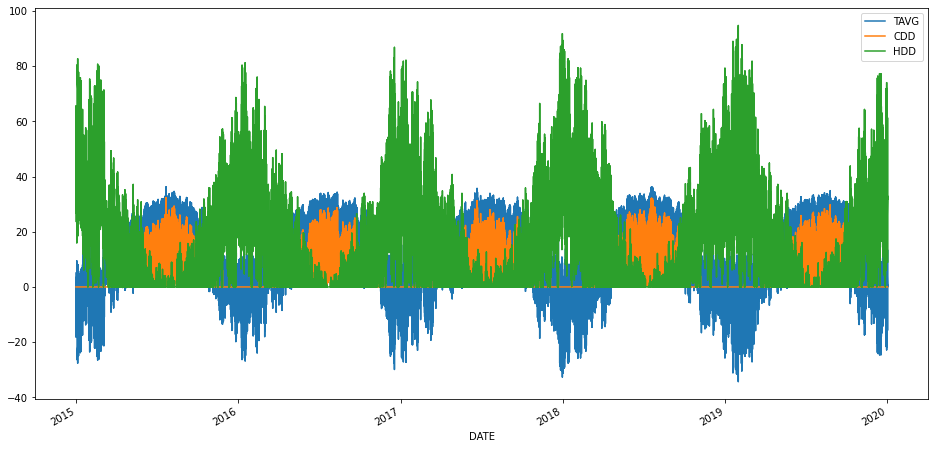

In [36]:
# todo: have one plot per station, add trendlines
weather_df[['DATE', 'TAVG', 'CDD', 'HDD']].set_index('DATE').sort_index().plot(figsize=(16,8))

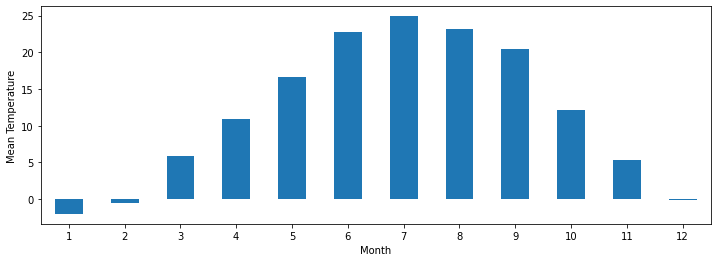

In [37]:
# from https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
# which has other good tips

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
weather_df.groupby(weather_df["DATE"].dt.month)["TAVG"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Mean Temperature");


In [38]:
weather_df.head()

,STATION,DATE,TMIN,TMAX,TAVG,CDD,HDD
0,CO_DENVER_INTL_AP,2015-01-01,-14.9,-3.2,-9.05,0.0,49.29
1,IA_SIOUX_CITY_GATEWAY_AP,2015-01-01,-16.0,1.1,-8.50,0.0,48.30
2,NM_CLAYTON_MUNI_AIR_PK,2015-01-01,-10.5,0.6,-5.70,0.0,43.26
3,IA_WATERLOO_MUNI_AP,2015-01-01,-11.6,2.2,-7.20,0.0,45.96
4,TX_ABILENE_RGNL_AP,2015-01-01,-6.0,-1.0,-4.80,0.0,41.64


In [39]:
weather_df.dtypes

STATION            object
DATE       datetime64[ns]
TMIN              float64
TMAX              float64
TAVG              float64
CDD               float64
HDD               float64
dtype: object

## Save out the weather dataframe

In [44]:
# save for later
weather_df.to_csv('dataframes/weather_df.csv.gz', compression="infer", index=False)
#weather_df.to_pickle('dataframes/weather_df.pickle.gz', compression="infer")

# Trying Feather
# weather_df.to_feather('dataframes/weather_df.feather.zstd', compression='zstd')

# Trying JSON
# weather_df.to_json('dataframes/weather_df.json.gz', compression='infer')


 * 
 *
 *
 * 
 *
 *
 
# Get list of holidays on which people might demand less power

using https://github.com/dr-prodigy/python-holidays


In [41]:
from datetime import date
# installed via "conda install holidays"
import holidays
from datetime import datetime

# ignore the days people still go to work:  MLK, Wash, Columb, Veterans; load is probably unchanged these days
# alternatively: one-hot encode these days
us_holidays = holidays.UnitedStates()

holiday_list = []

for date, name in sorted(holidays.US(state='OK', years=[int(i) for i in years_to_load]).items()):
    if name not in ("Martin Luther King Jr. Day", 
                    "Washington's Birthday", 
                    "Veterans Day (Observed)",
                    "Veterans Day",
                    "Columbus Day",
                   ):
          holiday_list.append([date, name])

# many people don't work Christmas Eve; try adding that?
holiday_list.append([datetime.strptime('2015-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2016-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2017-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2018-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2019-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
            
holiday_df = pd.DataFrame(holiday_list, columns = ['date', 'holiday']).sort_values('date')
holiday_df['date'] = pd.to_datetime(holiday_df.date)
holiday_df.set_index('date', inplace=True)

holiday_df.head()

,holiday
date,
2015-01-01,New Year's Day
2015-05-25,Memorial Day
2015-07-03,Independence Day (Observed)
2015-07-04,Independence Day
2015-09-07,Labor Day


In [42]:
import re
# clip the word "Observed"
holiday_df["holiday"].replace(' \(Observed\)','',regex=True, inplace = True)

holiday_df.head()

,holiday
date,
2015-01-01,New Year's Day
2015-05-25,Memorial Day
2015-07-03,Independence Day
2015-07-04,Independence Day
2015-09-07,Labor Day


## Save out the holiday dataframe

In [43]:
# save the holiday df
holiday_df.to_csv('dataframes/holiday_df.csv.gz', compression="infer")
#holiday_df.to_pickle('dataframes/holiday_df.pickle.gz', compression="infer")

# Trying Feather
#holiday_df.to_feather('dataframes/holiday_df.feather.zstd', compression='zstd')
# Trying JSON
# holiday_df.to_json('dataframes/holiday_df.json.gz', compression='infer')